In [14]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.io
basins = scipy.io.loadmat('/work/hfd/datasets/shapefiles/bsn_boundary.mat', simplify_cells=True, squeeze_me=True)['bsn_only']

In [15]:
R = 6.371e6

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = np.deg2rad(lon1), np.deg2rad(lat1), np.deg2rad(lon2), np.deg2rad(lat2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))

In [16]:
def unique_list(l):
    u = []
    for i, e in enumerate(l):
        # check if exists in unique_list or not
        if e not in u:
            u.append(e)
    return u

In [17]:
def split_non_consecutive_list(data, mod=np.inf):
    data = iter(np.array(data).astype("int64"))
    val = next(data)
    chunk = []
    try:
        while True:
            chunk.append(val)
            val = next(data)
            if ((val != np.mod(chunk[-1] + 1, mod)) and (val != np.mod(chunk[-1] + 2, mod)) and (val != np.mod(chunk[-1] + 3, mod))):
                yield chunk
                chunk = []
    except StopIteration:
        if chunk:
            yield chunk

def wrap_non_consecutive_listsoflists(lol, mod=np.inf):
    if lol[0][0] == np.mod(lol[-1][-1]+1, mod):
        if len(lol)==1:
            lol[0] = lol[0][1:]
        else:
            lol = [lol[-1]+lol[0]] + lol[1:-1]
    lol = [l for l in lol if len(l)>1]
    return lol

def consecutive_lists(data, mod=np.inf):
    if any(data):
        lol = [i for i in split_non_consecutive_list(data, mod=mod)]
        if any(lol):
            return wrap_non_consecutive_listsoflists(lol, mod=mod)
        else:
            return [[]]
    else:
        return [[]]

In [18]:
class Basin:
    def __init__(self, lons, lats, name, force_ccw=True):
        self.name = name
        self.lons = lons
        self.lats = lats
        self.remove_duplicate_points()

        self.section_is_clockwise = self.check_if_boundary_clockwise()
        self.make_counterclockwise()
    
    def check_if_boundary_clockwise(self):
        lons = np.append(self.lons, self.lons[0])
        lats = np.append(self.lats, self.lats[0])
        signed_area = 0.
        for i in range(self.N):
            signed_area += (lons[i+1]-lons[i])*(lats[i+1]+lats[i])
        return signed_area >= 0.
    
    def make_counterclockwise(self):
        if self.section_is_clockwise:
            self.lons = self.lons[::-1]
            self.lats = self.lats[::-1]
            
    def remove_duplicate_points(self, tol=5.e3):
        coords = [(lon, lat) for (lon, lat) in zip(self.lons, self.lats)]

        unique_coords = []
        for i, c in enumerate(coords):
            # check if exists in unique_list or not
            unique_lons = np.array([lon for (lon, lat) in unique_coords])
            unique_lats = np.array([lat for (lon, lat) in unique_coords])
            if np.any( haversine(c[0], c[1], unique_lons, unique_lats) < tol ):
                self.lons[i] = np.nan
                self.lats[i] = np.nan
            else:
                unique_coords.append(c)
        nan_idx = np.isnan(self.lons) | np.isnan(self.lats)
        self.lons = self.lons[~nan_idx]
        self.lats = self.lats[~nan_idx]
        self.N = len(self.lons)

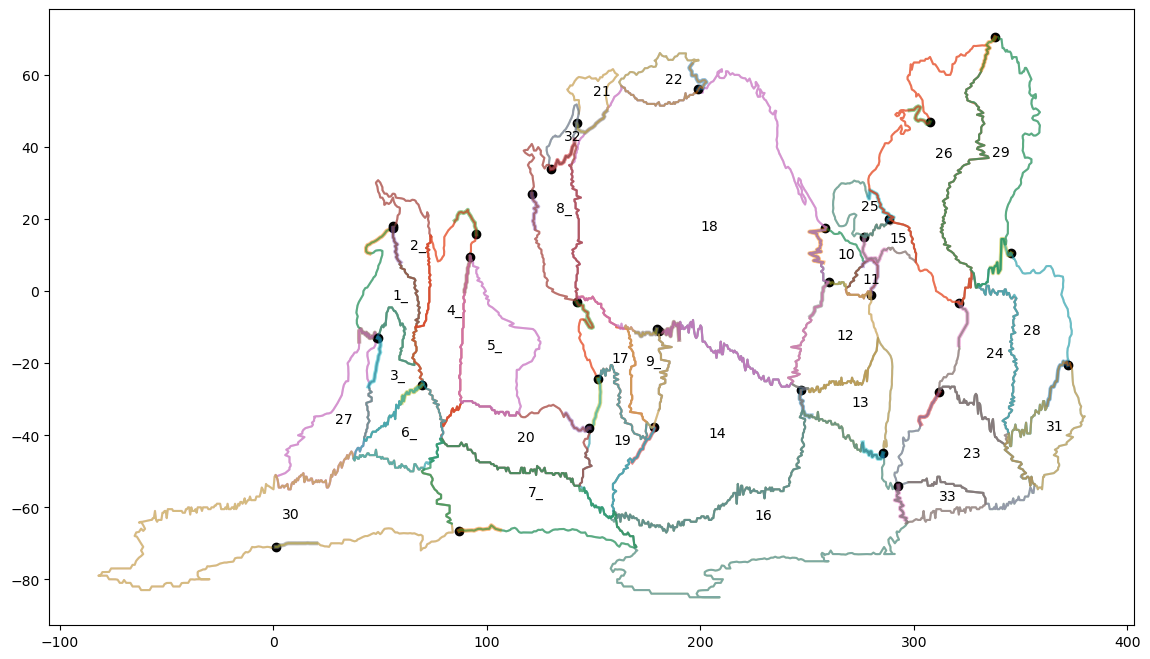

In [19]:
plt.figure(figsize=(14, 8))
for b in basins:
    B = Basin(b['bsn'][0], b['bsn'][1], str(b['bsn_num']))
    
    plt.plot(B.lons, B.lats, alpha=0.5)
    plt.plot(B.lons[0], B.lats[0], "ko")
    plt.plot(B.lons[0:20], B.lats[0:20], alpha=0.5, lw=3)
    
    plt.plot(B.lons, B.lats, alpha=0.5)
    plt.annotate(B.name, xy=(0.,0), xytext=(np.mean(B.lons), np.mean(B.lats)), textcoords="data")

In [20]:
def find_overlaps(B1, B2, fix_points_exact=False, tol=5.e3):
    overlaps = {B1.name:[], B2.name:[]}
    for i in range(B1.N):
        for j in range(B2.N):
            if haversine(B1.lons[i], B1.lats[i], B2.lons[j], B2.lats[j]) < tol:
                overlaps[B1.name].append(i)
                overlaps[B2.name].insert(0, j)
                if fix_points_exact:
                    B2.lons[j] = B1.lons[i]
                    B2.lats[j] = B1.lats[i]
    overlaps[B1.name] = consecutive_lists(overlaps[B1.name], mod=B1.N)
    overlaps[B2.name] = consecutive_lists(overlaps[B2.name], mod=B2.N)
    return group_overlaps(overlaps, B1, B2, tol=tol)

In [21]:
def group_overlaps(overlaps, B1, B2, tol=5.e3):
    grouped_overlaps = {B1.name: {}, B2.name: {}}
    group_num = 0
    for o2 in overlaps[B2.name]:
        for o1 in overlaps[B1.name]:
            if np.any(o1) and np.any(o2):
                for i in o1:
                    if np.any(haversine(B1.lons[i], B1.lats[i], B2.lons[o2], B2.lats[o2]) < tol):
                        grouped_overlaps[B1.name][group_num] = o1
                        grouped_overlaps[B2.name][group_num] = o2
                        group_num +=1
                        break
    return grouped_overlaps

In [22]:
class ConnectedBasins():
    def __init__(self, Basins):
        self.Basins = {Basin.name: Basin for Basin in Basins}
        self.Nb = len(self.Basins)
    
    def find_all_overlaps(self, tol=5.e3):
        self.overlaps = {}
        print("Finding overlaps for basin: ", end="")
        for i, (B1name, B1) in enumerate(self.Basins.items()):
            print(B1name, end=", ")
            for j, (B2name, B2) in enumerate(self.Basins.items()):
                if j<i:
                    overlaps = find_overlaps(B1, B2, tol=tol)
                    if len(overlaps[B1name]):
                        self.overlaps[(B1name, B2name)] = overlaps
                                
    def align_boundaries_with_overlap_sections(self):
        for Bname, B in self.Basins.items():
            overlap_list = [o for o in list(self.overlaps) if Bname in o]
            arbitrary_o = self.overlaps[overlap_list[0]][Bname]
            self.Basins[Bname] = roll_basin_boundary_to_align_with_overlap(B, arbitrary_o)
            
    def add_shared_corner_points(self):
        l = list(self.overlaps)
        corners = []

        for o in l:
            all_shared = [oo for oo in l if ((o[0] in oo) != (o[1] in oo))]
            for a in all_shared:
                if (((a[0], o[0]) in l) and ((a[0], o[1]) in l)):
                    corners.append([a[0], o[0], o[1]])
                if (((a[1], o[0]) in l) and ((a[1], o[1]) in l)):
                    corners.append([a[0], o[0], o[1]])

        corners = unique_list(corners)

        for c in corners:
            B = self.Basins[c[0]]

            idx01 = self.overlaps[(c[0], c[1])][c[0]]
            idx02 = self.overlaps[(c[0], c[2])][c[0]]

            dists = [
                (np.mod(idx01[0] -idx02[-1], B.N)),
                (np.mod(idx02[0] -idx01[-1], B.N)),
            ]
            inner = np.argmin(dists)

            if inner:
                coord = (B.lons[idx02[0]], B.lats[idx02[0]])
            else:
                coord = (B.lons[idx01[0]], B.lats[idx01[0]])

            # Find existing point closest to the corner and add it
            for cc in c:
                b = self.Basins[cc]
                if coord not in [(lon, lat) for (lon, lat) in zip(b.lons, b.lats)]:
                    dist = np.sqrt((b.lons - coord[0])**2 + (b.lats - coord[1])**2)
                    idx_insert = np.argmin(dist)
                    b.lons = np.concatenate((b.lons[:idx_insert], np.array([coord[0]]), b.lons[idx_insert:]))
                    b.lats = np.concatenate((b.lats[:idx_insert], np.array([coord[1]]), b.lats[idx_insert:]))
                    b.N = len(b.lons)

In [23]:
def roll_basin_boundary_to_align_with_overlap(B, oidx):
    roll_idx = -oidx[0][0]
    new_oidx = {onum: np.mod(np.array(o) + roll_idx, B.N) for (onum, o) in oidx.items()}
    
    B.lons = np.roll(B.lons, roll_idx)
    B.lats = np.roll(B.lats, roll_idx)
    
    for onum, o in new_oidx.items():
        gaps = np.array([i for i in range(np.min(o), np.max(o)+1) if i not in o])
        if any(gaps):
            B.lons[gaps] = np.nan
            B.lats[gaps] = np.nan

    nan_idx = np.isnan(B.lons) | np.isnan(B.lats)
    B.lons = B.lons[~nan_idx] 
    B.lats = B.lats[~nan_idx]
    B.N = len(B.lons)
        
    return B

['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2', '30', '31', '32', '33', '3', '4', '5', '6', '7', '8', '9']
{0: [82, 83, 84, 85, 86]} 128
{0: [130, 131, 132, 133, 134]} 199


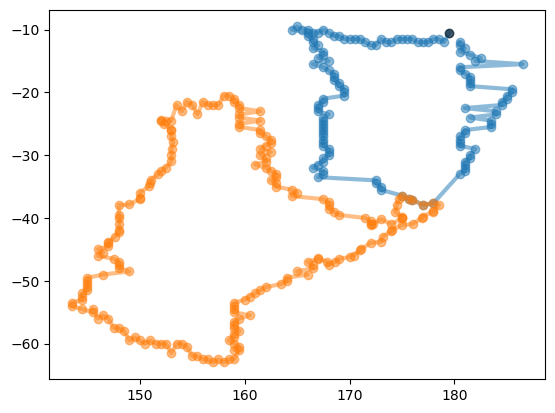

In [24]:
Basins_test = [Basin(b['bsn'][0], b['bsn'][1], str(b['bsn_num'].replace("_", ""))) for b in basins]
print([b.name for b in Basins_test])
Basins_test = ConnectedBasins(Basins_test)

B1idx = 9
B2idx = 19

B1 = Basins_test.Basins[str(B1idx)]
B2 = Basins_test.Basins[str(B2idx)]

o = find_overlaps(B1, B2)
print(o[B1.name], B1.N-1)
print(o[B2.name], B2.N-1)

plt.plot(B1.lons, B1.lats, "o-", lw=3., alpha=0.5)
plt.plot(B2.lons, B2.lats, "o-", lw=3., alpha=0.5)
plt.plot(B1.lons[0], B1.lats[0], "ko", lw=3., alpha=0.5)
if (any(o[B1.name]) or any(o[B2.name])):
    for oo in o[B1.name]:
        plt.plot(B1.lons[oo], B1.lats[oo], "o-", alpha=0.5, lw=0.5)
    for oo in o[B2.name]:
        plt.plot(B2.lons[oo], B2.lats[oo], ".-")

{0: [0, 1, 2, 3, 4]} 128
{0: [0, 1, 2, 3, 4]} 199


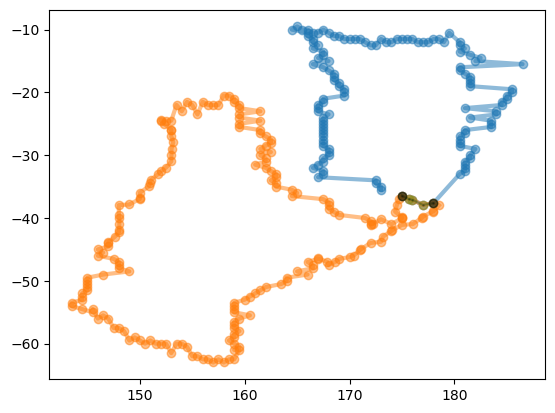

In [25]:
B1lons = B1.lons.copy()
B1lats = B1.lats.copy()

if len(o[B1.name]):
    B1 = roll_basin_boundary_to_align_with_overlap(B1, o[B1.name])
    B2 = roll_basin_boundary_to_align_with_overlap(B2, o[B2.name])
    plt.plot(B1.lons, B1.lats, "o-", lw=3., alpha=0.5)
    plt.plot(B2.lons, B2.lats, "o-", lw=3., alpha=0.5)
    o_new = find_overlaps(B1, B2)
    for oo in o_new[B1.name].values():
        plt.plot(B1.lons[oo], B1.lats[oo], "o-", alpha=0.2)
    for oo in o_new[B2.name].values():
        plt.plot(B2.lons[oo], B2.lats[oo], "k.-", markersize=2, alpha=0.2)
        
    print(o_new[B1.name], B1.N-1)
    print(o_new[B2.name], B2.N-1)
    
    plt.plot(B1.lons[0], B1.lats[0], "ko", lw=3., alpha=0.5);
    plt.plot(B2.lons[0], B2.lats[0], "ko", lw=3., alpha=0.5);

In [26]:
Basins = [Basin(b['bsn'][0], b['bsn'][1], str(b['bsn_num'].replace("_", ""))) for b in basins]
Basins = ConnectedBasins(Basins)
Basins.find_all_overlaps()

Finding overlaps for basin: 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 30, 31, 32, 33, 3, 4, 5, 6, 7, 8, 9, 

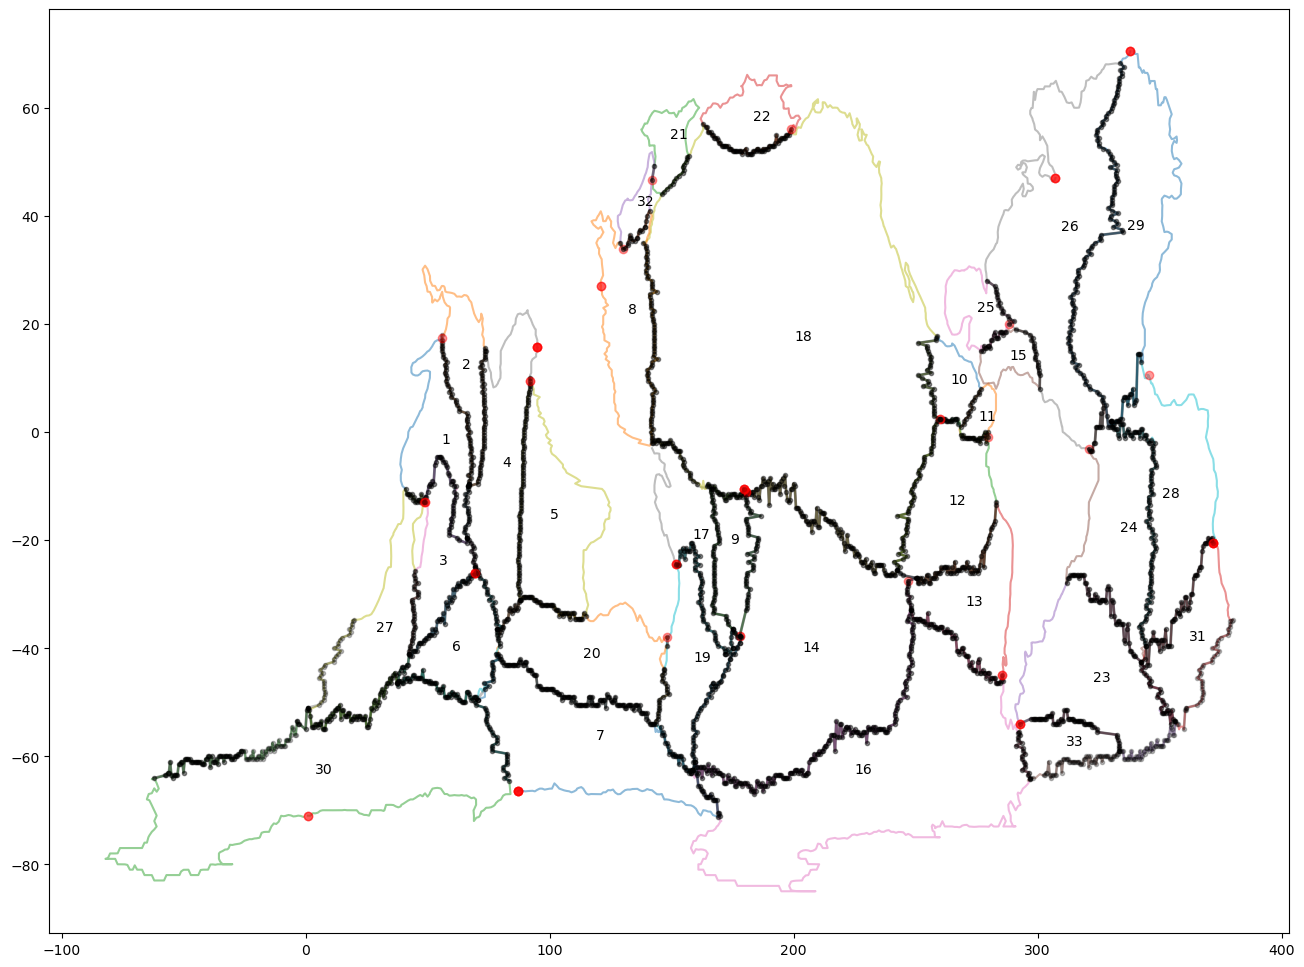

In [27]:
plt.figure(figsize=(16, 12))
for i, (Bname, B) in enumerate(Basins.Basins.items()):
    plt.plot(B.lons, B.lats, alpha=0.5)
    plt.annotate(B.name, xy=(np.mean(B.lons), np.mean(B.lats)), xytext=(np.mean(B.lons), np.mean(B.lats)), textcoords="data")
for (B1name, B2name), o in Basins.overlaps.items():
    for oo in o[B1name].values():
        plt.plot(Basins.Basins[B1name].lons[oo], Basins.Basins[B1name].lats[oo], "k.-", alpha=0.25, lw=2.)
    for oo in o[B2name].values():
        plt.plot(Basins.Basins[B2name].lons[oo], Basins.Basins[B2name].lats[oo], "k.-", alpha=0.25, lw=2.)
    plt.plot(Basins.Basins[B1name].lons[0], Basins.Basins[B1name].lats[0], "ro", alpha=0.4)

In [28]:
Basins.align_boundaries_with_overlap_sections()
Basins.find_all_overlaps()

Finding overlaps for basin: 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 30, 31, 32, 33, 3, 4, 5, 6, 7, 8, 9, 

('20', '19') {0: [259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280], 1: [0, 1]}

('31', '30') {0: [29, 30, 31], 1: [36, 37, 39]}

('33', '30') {0: [19, 20], 1: [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]}

('3', '27') {0: [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96], 1: [47, 48]}



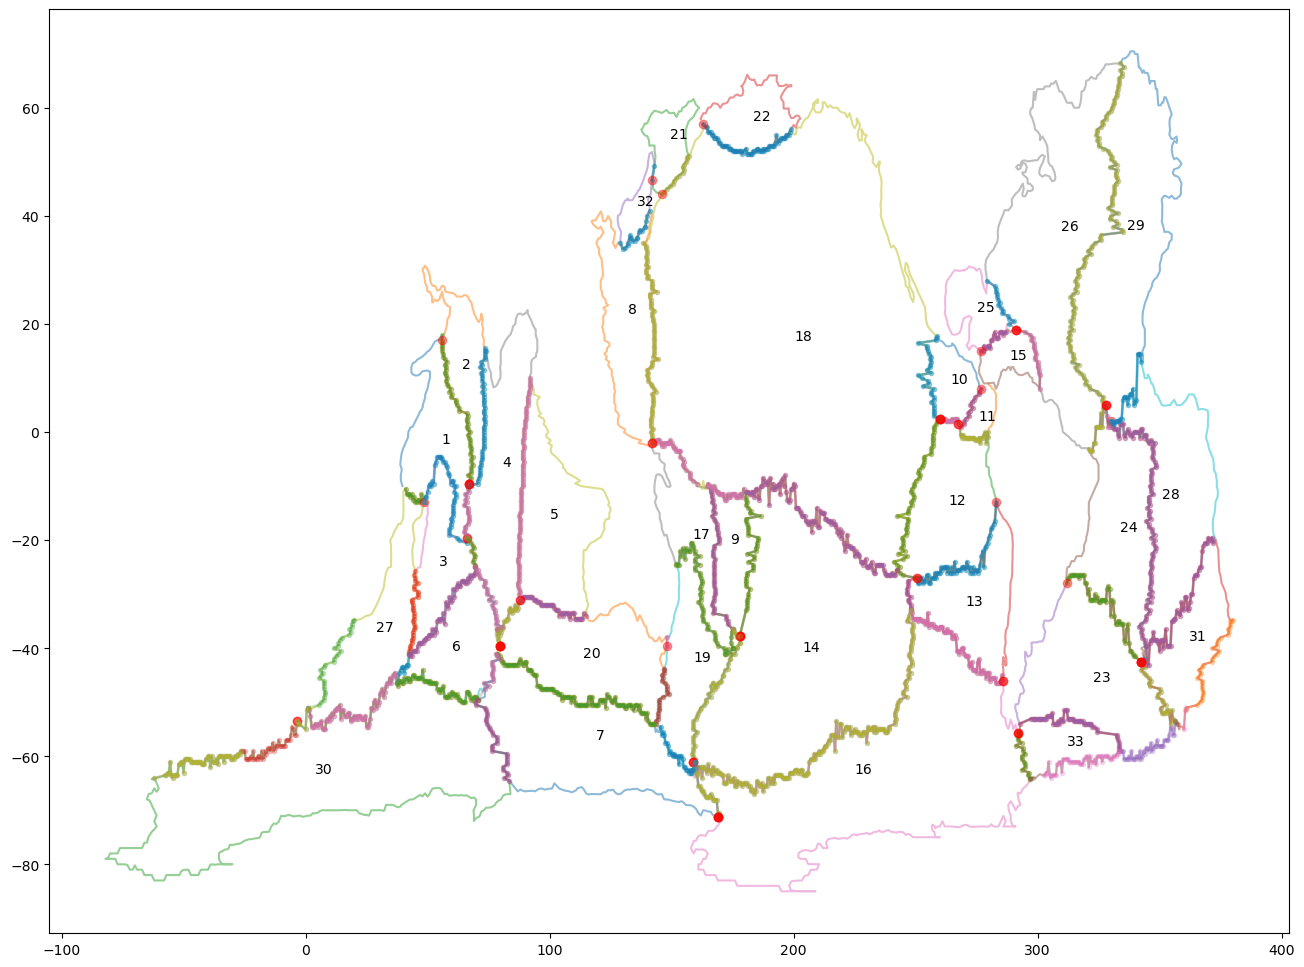

In [29]:
plt.figure(figsize=(16, 12))
for i, (Bname, B) in enumerate(Basins.Basins.items()):
    plt.plot(B.lons, B.lats, alpha=0.5)
    plt.annotate(B.name, xy=(np.mean(B.lons), np.mean(B.lats)), xytext=(np.mean(B.lons), np.mean(B.lats)), textcoords="data")
for (B1name, B2name), o in Basins.overlaps.items():
    if len(o[B1name])>1:
        print((B1name, B2name), o[B1name], end="\n\n")
    for oo in o[B1name].values():
        plt.plot(Basins.Basins[B1name].lons[oo], Basins.Basins[B1name].lats[oo], ".-", alpha=0.25, lw=2.)
    for oo in o[B2name].values():
        plt.plot(Basins.Basins[B2name].lons[oo], Basins.Basins[B2name].lats[oo], ".-", alpha=0.25, lw=2.)
    plt.plot(Basins.Basins[B1name].lons[0], Basins.Basins[B1name].lats[0], "ro", alpha=0.4)

### Delete any outlier points that are neither land, nor part of an overlapping boundary

In [34]:
import xarray as xr

In [31]:
topo = xr.open_dataset("/work/hfd/datasets/GEBCO_2020.nc4")
topo = topo.sel(lon=topo['lon'][::30], lat=topo['lat'][::30])
topo_shift = topo.assign_coords({'lon': xr.DataArray(topo['lon'].values+360., dims=("lon",))})
topo = xr.concat([topo, topo_shift], dim="lon")

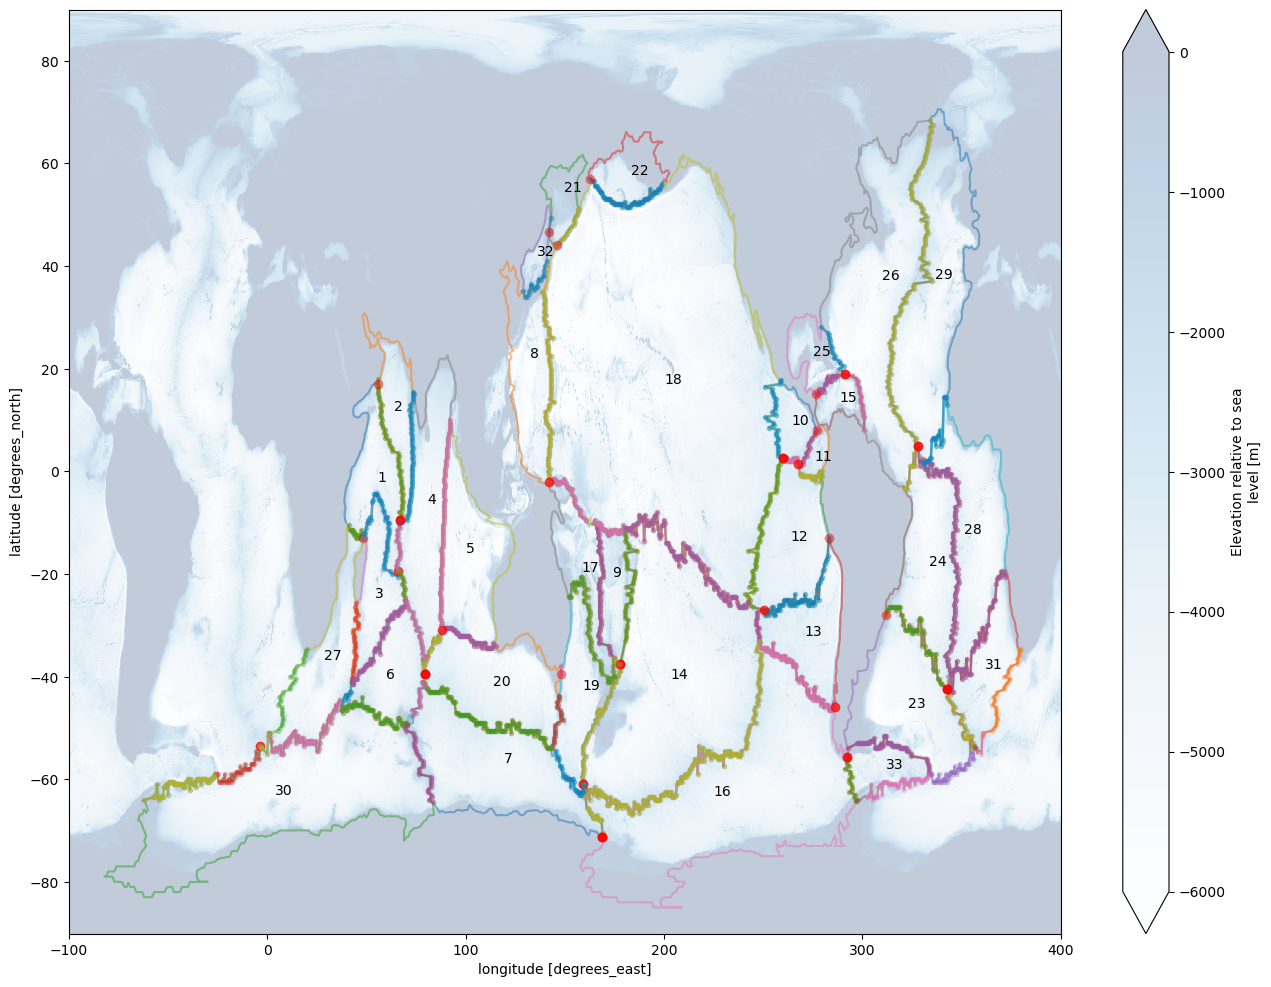

In [32]:
plt.figure(figsize=(16, 12))

ax = plt.subplot()
topo['elevation'].plot(ax=ax, vmin=-6000, vmax=0, cmap="Blues", alpha=0.25)

for i, (Bname, B) in enumerate(Basins.Basins.items()):
    ax.plot(B.lons, B.lats, alpha=0.5)
    ax.annotate(B.name, xy=(np.mean(B.lons), np.mean(B.lats)), xytext=(np.mean(B.lons), np.mean(B.lats)), textcoords="data")
for (B1name, B2name), o in Basins.overlaps.items():
    for oo in o[B1name].values():
        ax.plot(Basins.Basins[B1name].lons[oo], Basins.Basins[B1name].lats[oo], ".-", alpha=0.25, lw=2.)
    for oo in o[B2name].values():
        ax.plot(Basins.Basins[B2name].lons[oo], Basins.Basins[B2name].lats[oo], ".-", alpha=0.25, lw=2.)
    ax.plot(Basins.Basins[B1name].lons[0], Basins.Basins[B1name].lats[0], "ro", alpha=0.4)

ax.set_xlim(-100, 400);

In [43]:
for i, (Bname, B) in enumerate(Basins.Basins.items()):
    coords = xr.Dataset()
    coords["lon"] = xr.DataArray(B.lons, dims=("point",))
    coords["lat"] = xr.DataArray(B.lats, dims=("point",))
    land_mask = topo['elevation'].interp(coords) > -100.
    overlap_list = [o for o in list(Basins.overlaps) if Bname in o]
    all_overlaps = np.unique([ooo for o in overlap_list for (onum, oo) in Basins.overlaps[o][Bname].items() for ooo in oo])
    for j, (lat, lon) in enumerate(zip(B.lons, B.lats)):
        if not(land_mask.isel(point=j).values or j in all_overlaps):
            B.lons[j] = np.nan
            B.lats[j] = np.nan
    nan_idx = np.isnan(B.lons) | np.isnan(B.lats)
    B.lons = B.lons[~nan_idx]
    B.lats = B.lats[~nan_idx]
    B.N = len(B.lons)

In [44]:
Basins.find_all_overlaps()

Finding overlaps for basin: 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 30, 31, 32, 33, 3, 4, 5, 6, 7, 8, 9, 

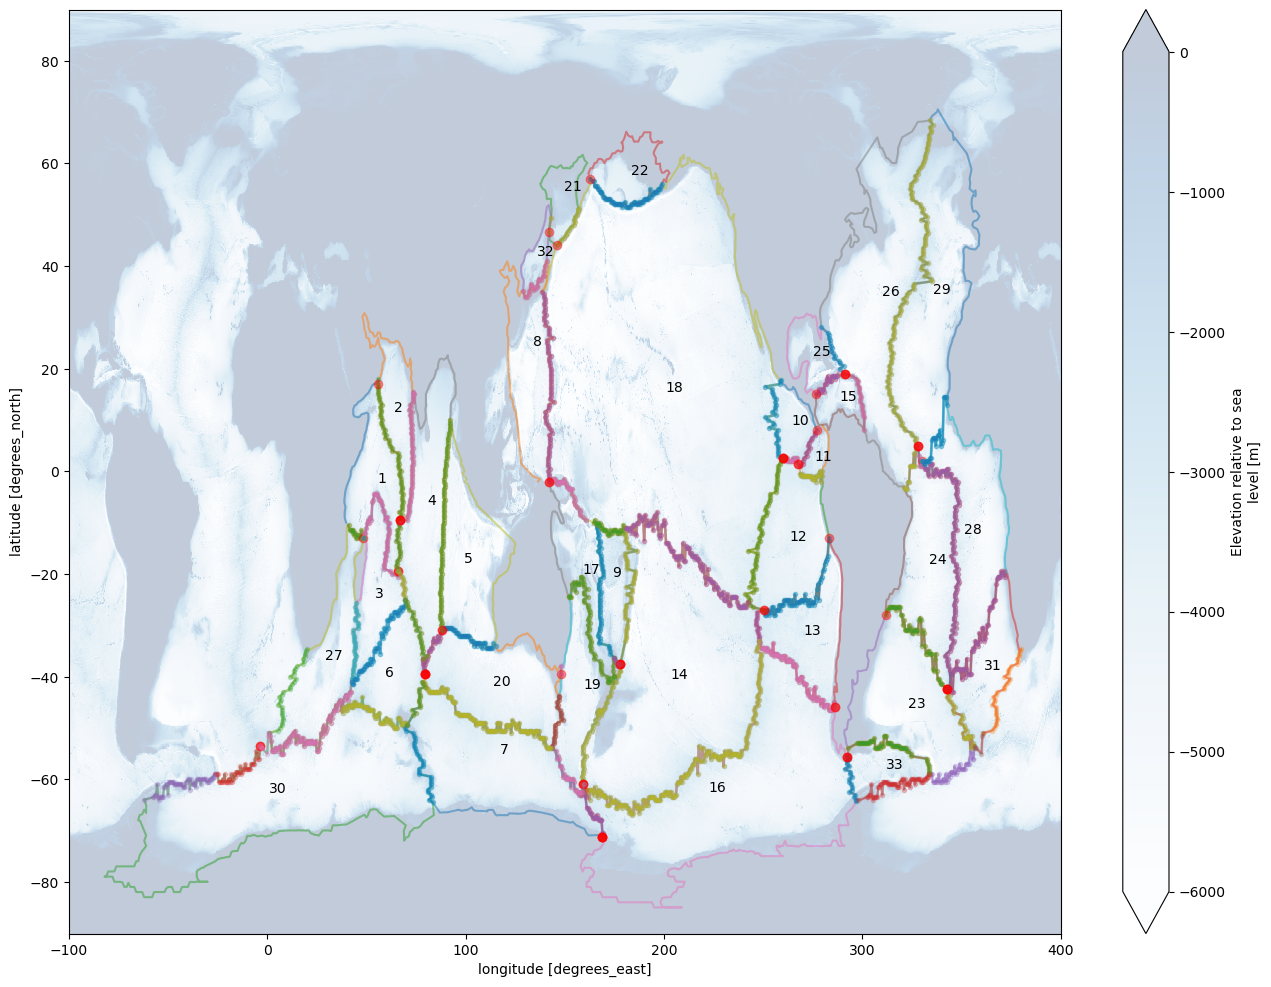

In [45]:
plt.figure(figsize=(16, 12))

ax = plt.subplot()
topo['elevation'].plot(ax=ax, vmin=-6000, vmax=0, cmap="Blues", alpha=0.25)

for i, (Bname, B) in enumerate(Basins.Basins.items()):
    ax.plot(B.lons, B.lats, alpha=0.5)
    ax.annotate(B.name, xy=(np.mean(B.lons), np.mean(B.lats)), xytext=(np.mean(B.lons), np.mean(B.lats)), textcoords="data")
for (B1name, B2name), o in Basins.overlaps.items():
    for oo in o[B1name].values():
        ax.plot(Basins.Basins[B1name].lons[oo], Basins.Basins[B1name].lats[oo], ".-", alpha=0.25, lw=2.)
    for oo in o[B2name].values():
        ax.plot(Basins.Basins[B2name].lons[oo], Basins.Basins[B2name].lats[oo], ".-", alpha=0.25, lw=2.)
    ax.plot(Basins.Basins[B1name].lons[0], Basins.Basins[B1name].lats[0], "ro", alpha=0.4)

ax.set_xlim(-100, 400);

### Save output in exact same format I received it in

In [46]:
clean_basins = [{'bsn': np.array([B.lons, B.lats]), 'bsn_num':Bname} for (Bname, B) in Basins.Basins.items()]
for b in range(len(clean_basins)):
    if len(clean_basins[b]['bsn_num']) == 1:
        clean_basins[b]['bsn_num'] = clean_basins[b]['bsn_num']+"_"

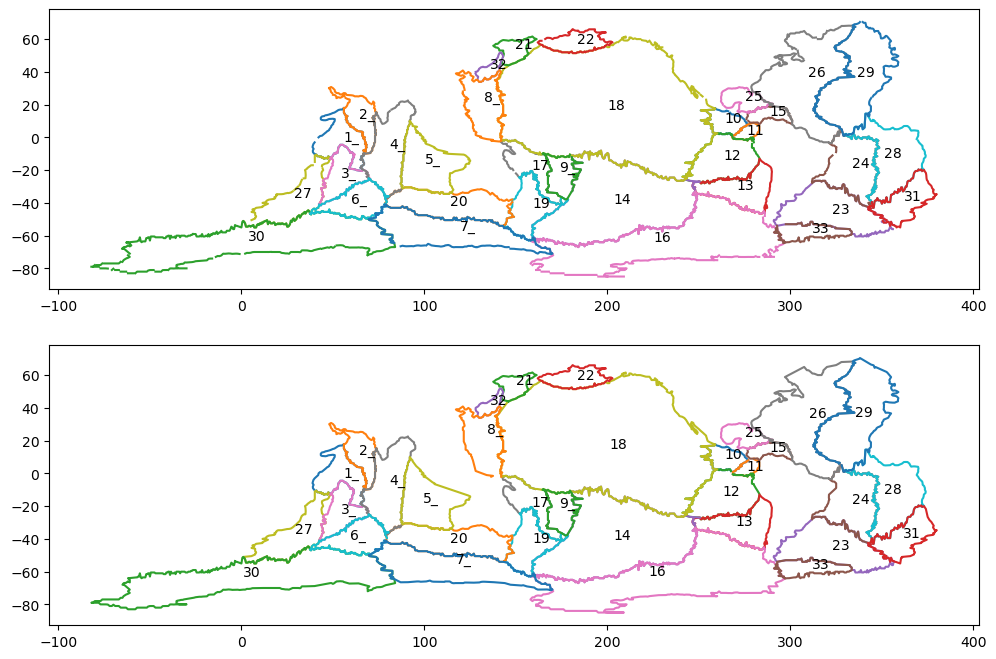

In [47]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
for b in basins:
    plt.plot(b['bsn'][0,:], b['bsn'][1,:])
    plt.annotate(b['bsn_num'], xy=(np.nanmean(b['bsn'][0,:]), np.nanmean(b['bsn'][1,:])), xytext=(np.nanmean(b['bsn'][0,:]), np.nanmean(b['bsn'][1,:])), textcoords="data")

plt.subplot(2,1,2)
for b in clean_basins:
    plt.plot(b['bsn'][0,:], b['bsn'][1,:])
    plt.annotate(b['bsn_num'], xy=(np.mean(b['bsn'][0,:]), np.mean(b['bsn'][1,:])), xytext=(np.mean(b['bsn'][0,:]), np.mean(b['bsn'][1,:])), textcoords="data")

In [48]:
scipy.io.savemat('/work/hfd/datasets/shapefiles/bsn_boundary_cleaned.mat', {'bsn_only':clean_basins})